<a href="https://colab.research.google.com/github/JackXubigbigpig/chromosome-structure-network/blob/main/CSN_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy import stats
import seaborn as sns;
#import math
sns.set()

In [3]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving exp_input.csv to exp_input.csv
User uploaded file "exp_input.csv" with length 5291232 bytes


               0         1      2
0        9400000   9400000  277.0
1        9400000   9450000    1.0
2        9400000   9550000    5.0
3        9550000   9550000  123.0
4        9550000   9600000    2.0
...          ...       ...    ...
231988  47900000  48100000   56.0
231989  47950000  48100000   69.0
231990  48000000  48100000  107.0
231991  48050000  48100000  416.0
231992  48100000  48100000  135.0

[231993 rows x 3 columns]
964


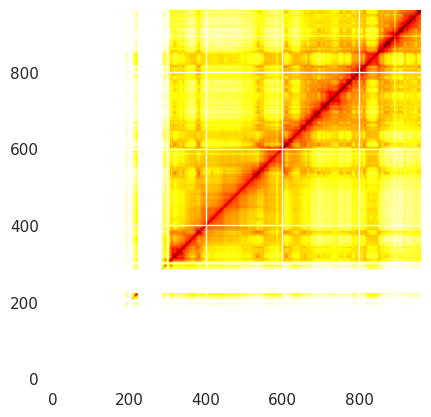

In [4]:
# define input name
# define bin size,resolution
# This dataset is 50kb resolution
# bins = max//res
input_file_name = 'exp_input.csv'
res = 50000
dft = pd.read_csv(input_file_name, sep='\t', header=None)
print(dft)
max_length = dft[0].max()
bins = (max_length // res) + 2
print(bins)

data = np.zeros((bins, bins))
# d_p = 0

file = open(input_file_name, 'r')
for line in file:
    [x, y, z] = line.split()
    data[int(x)//res][int(y)//res] = z
#    if float(z)<2.2 and float(x)/50000<=346 and float(y)/50000<=346:
#        d_p = d_p +1
file.close()
#print(data)
#print(d_p)

for i in range(0,bins):
    for j in range(i+1,bins):
        data[j,i] = data[i,j]
#print(data)
plt.imshow(np.log2(data+1), cmap='hot_r', origin='lower')
plt.show()

In [5]:
# Which part of matrix you want to analyze
# define starting point and size of the part (bins)
# Start from
stp = 304
# Size
pt_size = 660

data_part = np.zeros((pt_size, pt_size))
for i in range(0,pt_size):
    for j in range(0,pt_size):
        data_part[i,j] = data[i+stp,j+stp]

print(data_part)

[[1.7640e+03 3.6200e+02 1.6500e+02 ... 1.0000e+00 1.0000e+00 0.0000e+00]
 [3.6200e+02 8.1300e+02 1.7900e+02 ... 3.0000e+00 0.0000e+00 0.0000e+00]
 [1.6500e+02 1.7900e+02 8.2200e+02 ... 3.0000e+00 0.0000e+00 0.0000e+00]
 ...
 [1.0000e+00 3.0000e+00 3.0000e+00 ... 1.7409e+04 4.1600e+02 0.0000e+00]
 [1.0000e+00 0.0000e+00 0.0000e+00 ... 4.1600e+02 1.3500e+02 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]]


In [6]:
# Ice normaliztion
# https://members.cbio.mines-paristech.fr/~nvaroquaux/iced/tutorial/index.html
# install iced package if not installed yet
!pip install -U iced
from iced import datasets
from iced import filter
from iced import normalization

# Loading our dataset
counts = data_part
print(counts.shape)
# input bin here
lengths =np.array([pt_size])
print(lengths.sum())

# Filtering and normalizing contact count data
normed = filter.filter_low_counts(counts, lengths=lengths, percentage=0.04)
normed = normalization.ICE_normalization(normed)
#normed = pd.DataFrame(normed)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 4.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for iced: filename=iced-0.5.13-cp310-cp310-linux_x86_64.whl size=2580286 sha256=2cf9a398c2db03f13596fa189ec2fa7c6cd2fdc06e2a018dcc40f4d557f7de2b
  Stored in directory: /root/.cache/pip/wheels/1d/5f/03/4cb552d2c5bf434c80541859ed82a64edf508171114024ac47
Successfully built iced


/usr/local/lib/python3.10/dist-packages/iced/normalization/_ca_utils.py:8: UserWarning: The API of this module is likely to change. Use only for testing purposes
  warnings.warn(


(660, 660)
660


In [7]:
# Now remove the diagonal and do distance normalization
df1 = pd.DataFrame(normed, columns=None)

for i in range(0, pt_size):
    for j in range(0, pt_size):
        if i==j:
            df1.iloc[i,j] = 0

# Fragments that are closer on the genome have a greater probability of random contact.
# So we need to remove the effect of physical distance on the probability of contact.
# this code do seq distance scale.
dim = pt_size
avgd = np.ones(dim)
csn = np.zeros((dim,dim))

filename = 'exclude_diag.con'
if os.path.exists(filename):
    os.remove(filename)

#input iced-normed matrix here
df1ds = df1

#rename the output
fp=open('exclude_diag.con','w')

for i in range (1, dim+1):
    line1 = pd.DataFrame(df1ds, columns= [i-1])
    for j in range (1, dim+1):
       csn[i-1, j-1] = line1.iloc[j-1, 0]

for i in range (1, dim+1): # distance  to the dignal
    count=0.0
    k = 0
    for j in range (1, dim-i+1+1):
       count+= csn[j-1,j-1+i-1]
       #print("%4d %4d" %(j-1,j-1+i-1))
       k = k+1
    avgd[i-1]=count/k


for i in range (1, dim+1):
    line1 = pd.DataFrame(df1ds, columns= [i-1])
    for j in range (1, dim+1):
        if (avgd[abs(i-j)]<0.00001):
                print(" %4d %4d %f" % (i, j, line1.iloc[j-1, 0]), file=fp)
        else :
                print(" %4d %4d %f" % (i, j, line1.iloc[j-1, 0] / avgd[abs(i-j)]), file=fp)

In [ ]:
#from google.colab import files
#files.download('exclude_diag.con')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

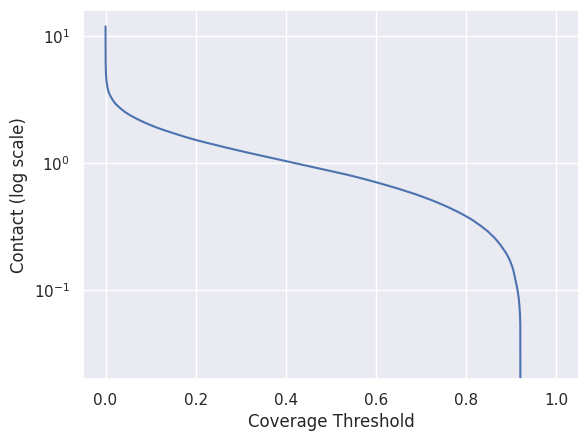

In [10]:
# read .con
con = np.loadtxt("exclude_diag.con")
con = pd.DataFrame(con, columns=None)
con.sort_values(2,inplace= True)
#print(con)

# convert to full matrix
ma = np.zeros((dim,dim))
file = open('exclude_diag.con', 'r')
for line in file:
    [x, y, z] = line.split()
    ma[int(x)-1][int(y)-1] = z
#    ma[int(x)][int(y)] = z
file.close()
df=pd.DataFrame(ma)

# count non-zero
con_nonzero = con.loc[con[2] != 0].copy()
con_nonzero.sort_values(2,inplace= True)
#print(con_nonzero)
#con_nozero = con.loc[con[2] != 0].copy()
#con_nozero.sort_values(2, inplace=True, ascending=False)  # Sort in descending order
#print(con_nozero)
con1 = con.copy()
con1.sort_values(2, inplace=True, ascending=False)  # Sort in descending order
con1.reset_index(drop=True, inplace=True)  # Reset the index
sorted_column = con1[2]
#print(con1)
#print(sorted_column)

sorted_column = con1[2]

# Calculate the percentage values for the x-axis
ratio_values = np.linspace(0, 1, len(sorted_column))
# Plot the data
plt.plot(ratio_values, sorted_column)
# Set the y-axis to a logarithmic scale
plt.yscale('log')

plt.xlabel('Coverage Threshold')
plt.ylabel('Contact (log scale)')
# plt.title('Plot with Sorted Column on Log Scale')

# Show the plot
plt.show()

In [11]:
# cutoff below % of the whole matrix, larger the value/, more cuttoff(type in the "being cutoff" value before /100)
# e.g. 60/100 will cut off the lowest 60%, retaining only the top 40% of higher contacts
cutoff = con.iloc[int(con.shape[0]*60/100),2]
print(cutoff)

1.035507


In [12]:
#cut matrix
for i in range(0,dim):
    for j in range(0, dim):
        if df.iloc[i,j] < cutoff:
            df.iloc[i,j] = 0

filename = 'cutoff.txt'
if os.path.exists(filename):
    os.remove(filename)
df.to_csv("cutoff.txt", sep=' ', index=0, header=0)

#cut con and save col.1&2
con_cutoff = con.loc[con[2] >= cutoff]
s12 = con_cutoff.iloc[:,0:2]
#print(s12)

filename = 'con_cutoff.txt'
if os.path.exists(filename):
    os.remove(filename)
s12.to_csv("con_cutoff.txt", sep=' ', index=0, header=0)

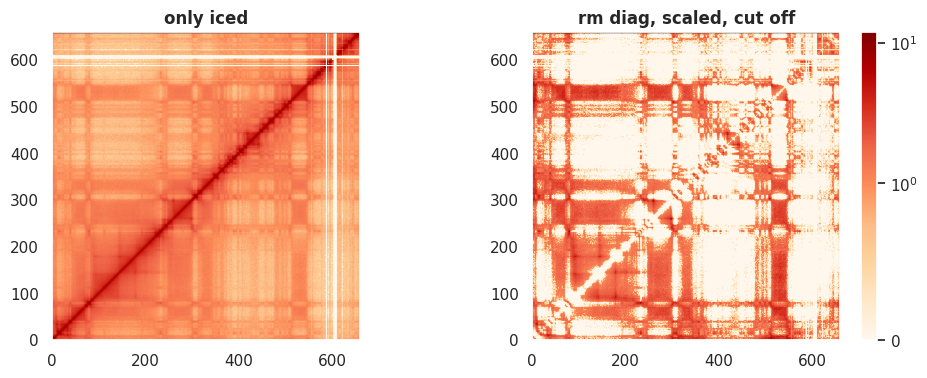

In [14]:
# Plotting the results using matplotlib

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
cut = np.genfromtxt("cutoff.txt", delimiter=' ')
origin = normed
lengths =np.array([dim])

axes[0].imshow(origin, cmap="OrRd", norm=colors.SymLogNorm(1),
               origin="lower",
               extent=(0, len(origin), 0, len(origin)))

[axes[0].axhline(i, linewidth=1, color="#000000") for i in lengths.cumsum()]
[axes[0].axvline(i, linewidth=1, color="#000000") for i in lengths.cumsum()]

axes[0].set_title("only iced", fontweight="bold")


m = axes[1].imshow(cut, cmap="OrRd", norm=colors.SymLogNorm(1),
                   origin="lower",
                   extent=(0, len(cut), 0, len(cut)))

[axes[1].axhline(i, linewidth=1, color="#000000") for i in lengths.cumsum()]
[axes[1].axvline(i, linewidth=1, color="#000000") for i in lengths.cumsum()]
cb = fig.colorbar(m)
axes[1].set_title("rm diag, scaled, cut off", fontweight="bold")
axes[0].grid(False)
axes[1].grid(False)

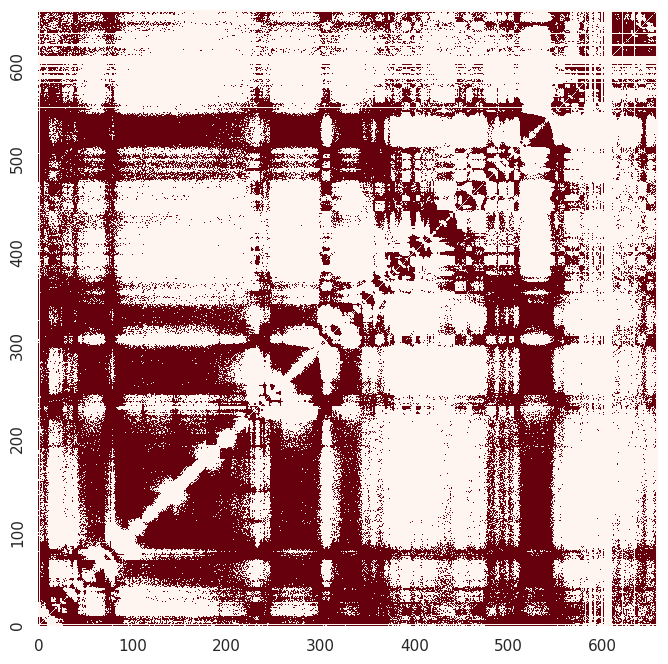

In [16]:
plt.figure(figsize = (8,8))
df11 = pd.DataFrame(cut, index=None, columns=None)
#ax = sns.heatmap(df11, cmap="Reds",vmax=0.1, xticklabels=10, yticklabels=10)
ax = sns.heatmap(df11, cmap="Reds",vmax=0.00000001, cbar=False, xticklabels=100, yticklabels=100).invert_yaxis()
#plt.savefig("testcutoff")

In [17]:
import networkx as nx

# Convert pandas DataFrame to NetworkX graph
G = nx.from_pandas_edgelist(s12, source=0, target=1)

# Convert NetworkX graph to adjacency list
# adj_list = nx.to_dict_of_lists(G)

# print(adj_list)

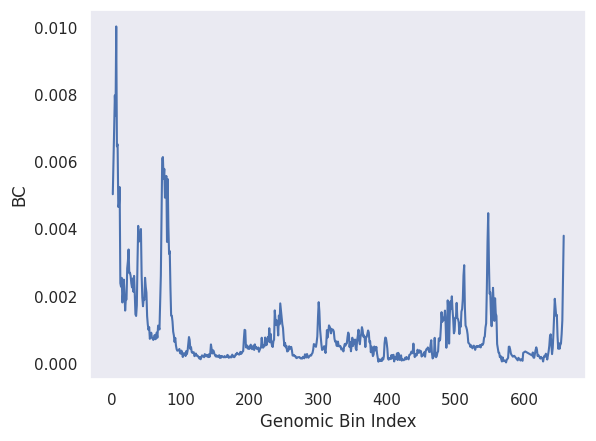

In [18]:
# Caculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)
# Sort the betweenness centrality dictionary by source node
BC = dict(sorted(betweenness_centrality.items(), key=lambda item: item[0]))
#print(BC)
# Save the sorted betweenness centrality to a txt file
filename = 'BC.txt'
if os.path.exists(filename):
    os.remove(filename)
with open(filename, 'w') as file:
    for node, value in BC.items():
        file.write(f"{node} {value}\n")

x_data = list(BC.keys())
y_data = list(BC.values())
plt.plot(x_data, y_data)
plt.xlabel('Genomic Bin Index')
plt.ylabel('BC')
plt.grid(False)
plt.show()

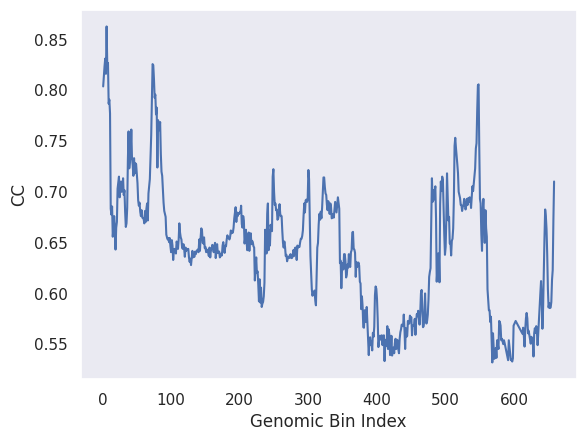

In [19]:
# Caculate closeness centrality
closeness_centrality = nx.closeness_centrality(G)
CC = dict(sorted(closeness_centrality.items(), key=lambda item: item[0]))
#print(CC)
filename = 'CC.txt'
if os.path.exists(filename):
    os.remove(filename)
with open(filename, 'w') as file:
    for node, value in CC.items():
        file.write(f"{node} {value}\n")

x_data = list(CC.keys())
y_data = list(CC.values())
plt.plot(x_data, y_data)
plt.xlabel('Genomic Bin Index')
plt.ylabel('CC')
plt.grid(False)
plt.show()

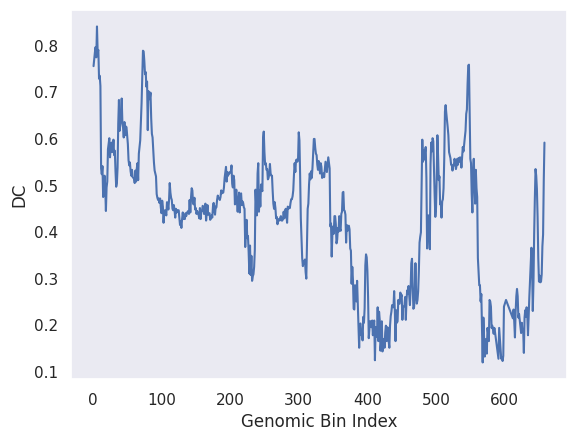

In [20]:
# Caculate degree centrality
degree_centrality = nx.degree_centrality(G)
DC = dict(sorted(degree_centrality.items(), key=lambda item: item[0]))
#print(DC)
filename = 'DC.txt'
if os.path.exists(filename):
    os.remove(filename)
with open(filename, 'w') as file:
    for node, value in DC.items():
        file.write(f"{node} {value}\n")

x_data = list(DC.keys())
y_data = list(DC.values())
plt.plot(x_data, y_data)
plt.xlabel('Genomic Bin Index')
plt.ylabel('DC')
plt.grid(False)
plt.show()

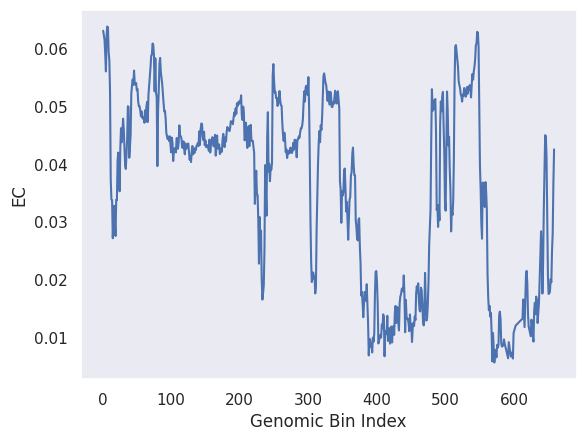

In [21]:
# Caculate eigenvector centrality
eigenvector_centrality = nx.eigenvector_centrality(G)
EC = dict(sorted(eigenvector_centrality.items(), key=lambda item: item[0]))
#print(EC)
filename = 'EC.txt'
if os.path.exists(filename):
    os.remove(filename)
with open(filename, 'w') as file:
    for node, value in EC.items():
        file.write(f"{node} {value}\n")

x_data = list(EC.keys())
y_data = list(EC.values())
plt.plot(x_data, y_data)
plt.xlabel('Genomic Bin Index')
plt.ylabel('EC')
plt.grid(False)
plt.show()

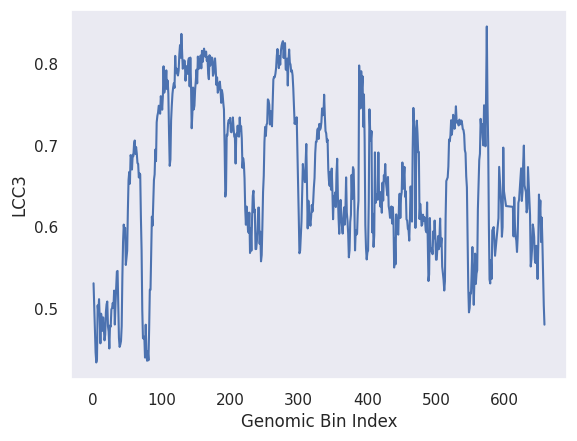

In [22]:
# Caculate local clustering coefficient 3
clustering = nx.clustering(G)
LCC3 = dict(sorted(clustering.items(), key=lambda item: item[0]))
#print(LCC3)
filename = 'LCC3.txt'
if os.path.exists(filename):
    os.remove(filename)
with open(filename, 'w') as file:
    for node, value in LCC3.items():
        file.write(f"{node} {value}\n")

x_data = list(LCC3.keys())
y_data = list(LCC3.values())
plt.plot(x_data, y_data)
plt.xlabel('Genomic Bin Index')
plt.ylabel('LCC3')
plt.grid(False)
plt.show()

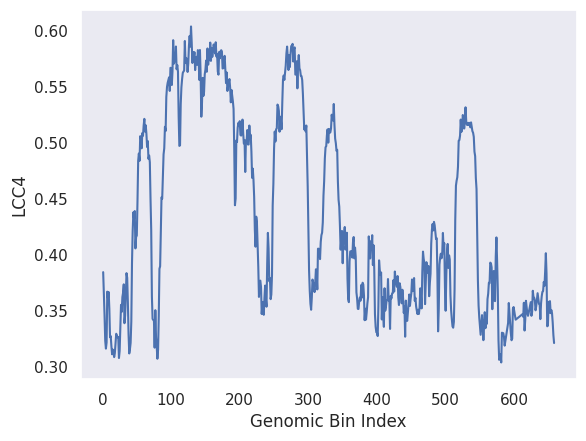

In [24]:
# Caculate local clustering coefficient 4
square_clustering = nx.square_clustering(G)
LCC4 = dict(sorted(square_clustering.items(), key=lambda item: item[0]))
#print(LCC4)
filename = 'LCC4.txt'
if os.path.exists(filename):
    os.remove(filename)
with open(filename, 'w') as file:
    for node, value in LCC4.items():
        file.write(f"{node} {value}\n")

x_data = list(LCC4.keys())
y_data = list(LCC4.values())
plt.plot(x_data, y_data)
plt.xlabel('Genomic Bin Index')
plt.ylabel('LCC4')
plt.grid(False)
plt.show()

In [ ]:
# Download the result here
#from google.colab import files
#files.download('BC.txt')
#files.download('CC.txt')
#files.download('DC.txt')
#files.download('EC.txt')
#files.download('LCC3.txt')
#files.download('LCC4.txt')